In [1]:
import torch
from math import pi,sqrt,log,e
from time import time
from matplotlib import pyplot
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
dtype = torch.float
device = torch.device("cuda:1")


In [48]:
class BiLU(torch.nn.Module):
    """Bijective linear unit
    Slope is alpha + delta*sign(x)    
    """
    def __init__(self, alpha=1., delta=.9):
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.tensor(alpha),requires_grad = False)
        self.delta = torch.nn.Parameter(torch.tensor(delta),requires_grad = False)

    def forward(self, input):
        return input * self.alpha + self.delta * torch.abs(input)
    
    
class NormBiTanh(torch.nn.Module):
    """Bijective alpha*Tanh + (1-alpha)*x activation"""
    def __init__(self,alpha=0.3):
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.tensor(alpha),requires_grad = False)
    
    def forward(self, input):
        return self.alpha*input + (1-self.alpha)*torch.tanh(input)
    
class OverallAffineLayer(torch.nn.Module):
    """Bijective linear unit
    Slope is alpha + delta*sign(x)    
    """
    def __init__(self, alpha=10., delta=0.):
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.tensor(alpha),requires_grad = True)
        self.delta = torch.nn.Parameter(torch.tensor(delta),requires_grad = True)

    def forward(self, input):
        return input * self.alpha + self.delta   
    
class ResFlow(torch.nn.Module):
    def __init__(self,block=None):
        super().__init__()
        assert isinstance(block,torch.nn.Module)
        self.block = block
        
    def forward(self,input):
        return input + self.block(input)
    

class NNFlow(torch.nn.Module):
    def __init__(self,*,d,nh,dh,activation_layer_class=NormBiTanh):
        super().__init__()
        self.d = d
        
        assert d <= dh, "The hidden dimension must be larger than the in/out dimension for bijectivity"
        
        ll = torch.nn.Linear(d,dh,bias=False)
        torch.nn.init.normal_(ll.weight,std=0.1/d/nh)
        ll.weight.data += torch.eye(dh,d).to(ll.weight.data.device)
        layers = [
            ll,
            activation_layer_class(),            
        ]
        
        for i in range(nh):
            ll = torch.nn.Linear(dh,dh,bias=False)
            torch.nn.init.normal_(ll.weight,std=0.1/d/nh)
            ll.weight.data += torch.eye(dh).to(ll.weight.data.device)
            layers.append(ll)
            layers.append(activation_layer_class())
            
        ll = torch.nn.Linear(dh,d,bias=False)
        torch.nn.init.normal_(ll.weight,std=0.1)
        ll.weight.data += 5.*torch.eye(d,dh).to(ll.weight.data.device)
        layers.append(ll)
        layers.append(activation_layer_class())
        
        self.flow = (torch.nn.Sequential(*layers))
        
    
    def forward(self,xj):
        """xj.shape = (n_batch,d+1)"""
        x = xj[:,:self.d].detach()
        log_j = xj[:,-1]
        
        x.requires_grad = True
        y = self.flow(x)
        
        n_batch = xj.shape[0]
        
        Jx = torch.zeros(n_batch,self.d,self.d).to(log_j.device)
        directions = torch.eye(self.d).to(log_j).unsqueeze(0).repeat(n_batch,1,1)
        
        for i in range(self.d):
            Jx[:,i,:] = torch.autograd.grad(y,x,directions[:,i,:],allow_unused=True,create_graph=True,retain_graph=True)[0]
        x.requires_grad = False
        x.grad = None        
        
        logdetJ = torch.log(torch.abs(torch.det(Jx)))
        return torch.cat([y.detach(),(log_j+logdetJ).unsqueeze(1)],1)
    
    
class LinearFlow(NNFlow):    
    def __init__(self,*,d):
        torch.nn.Module.__init__(self)
        self.d = d
        

        layers =[torch.nn.Linear(d,d,bias=False)]
        torch.nn.init.normal_(layers[0].weight,std=0.1/d)
        layers[0].weight.data += torch.eye(d).to(layers[0].weight.data.device)
        
        self.flow = (torch.nn.Sequential(*layers))
        
        
class SigmoidFlow(NNFlow):    
    def __init__(self,*,d):
        torch.nn.Module.__init__(self)        
        self.d = d
        layers =[torch.nn.Sigmoid()]
        
        self.flow = (torch.nn.Sequential(*layers))
    
class FactorizedFlowPrior(torch.nn.Module):
    def __init__(self,*,d,prior_1d):
        super().__init__()
        self.d=d        
        self.prior=prior_1d
    
    def forward(self,n_batch):
        # Generate normally distributed points
        x = self.prior.sample((n_batch,self.d))
        # Compute their per-dimension log PDF and sum them across dimenions to get the log PDF then add a batch dimension    
        log_j = -torch.sum(self.prior.log_prob(x),-1).unsqueeze(-1)
        return torch.cat([x,log_j],-1)
        
    
    

In [46]:
# Checking the jacobian on a pure linear transform

prior_mu =  torch.tensor(0.).to(device)
prior_sig =  torch.tensor(100.).to(device)
prior = torch.distributions.normal.Normal(prior_mu,prior_sig)

sampler = FactorizedFlowPrior(d=2,prior_1d=prior)
nnflow = LinearFlow(d=2)

nnflow.cuda(device=device)

nbatch=100000
zj = sampler(nbatch)
xlj = nnflow(zj)
j = torch.exp(xlj[:,-1])
v,r=torch.var_mean(j)
v=v.detach().cpu().item()
r=r.detach().cpu().item()
print("{}+/-{}".format(r,sqrt(v/nbatch)))
print(torch.mean(xlj[:,-1]-(zj[:,-1])))
print(torch.log(torch.abs(torch.det(nnflow.flow[0].weight.data))))

1701350.5+/-803564.500180611
tensor(-0.0566, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(-0.0566, device='cuda:1')


In [4]:
# Checking the jacobian on a pure sigmoid transform


prior_mu =  torch.tensor(0.).to(device)
prior_sig =  torch.tensor(3.).to(device)
prior = torch.distributions.normal.Normal(prior_mu,prior_sig)

sampler = FactorizedFlowPrior(d=2,prior_1d=prior)
nnflow = SigmoidFlow(d=2)

nnflow.cuda(device=device)

nbatch=10000
zj = sampler(nbatch)
xlj = nnflow(zj)
j = torch.exp(xlj[:,-1])
v,r=torch.var_mean(j)
v=v.detach().cpu().item()
r=r.detach().cpu().item()
print("{}+/-{}".format(r,sqrt(v/nbatch)))

1.0031155347824097+/-0.00921735688367692


In [5]:
sj1=torch.exp(xlj[:,-1]-zj[:,-1])
sj2=xlj[:,0]*(1-xlj[:,0])*xlj[:,1]*(1-xlj[:,1])
torch.all(torch.abs(sj1-sj2)/sj1 < 1.e-3)

tensor(True, device='cuda:1')

In [6]:
from math import sqrt,pi
def normal(x,s):
    return(torch.exp(-(x/s)**2/2.)/sqrt(2.*pi*s**2))

In [7]:
torch.abs(1/(normal(zj[:,0],3.)*normal(zj[:,1],3.)))

tensor([ 60.2437, 141.5886,  56.8031,  ...,  77.8199,  77.4746,  63.5722],
       device='cuda:1')

In [8]:
 torch.exp(zj[:,-1])

tensor([ 60.2437, 141.5885,  56.8031,  ...,  77.8199,  77.4746,  63.5722],
       device='cuda:1')

In [9]:
torch.all(torch.abs(1/(normal(zj[:,0],3.)*normal(zj[:,1],3.)) -  torch.exp(zj[:,-1]))/torch.exp(zj[:,-1])<1.e-4)

tensor(True, device='cuda:1')

In [2]:
# Checking the jacobian on a pure linear +sigmoid transform

sig=1.
prior_mu =  torch.tensor(0.).to(device)
prior_sig =  torch.tensor(sig).to(device)
prior = torch.distributions.normal.Normal(prior_mu,prior_sig)

sampler = FactorizedFlowPrior(d=2,prior_1d=prior)
lflow = LinearFlow(d=2)
sflow = SigmoidFlow(d=2)

sampler.cuda(device=device)
lflow.cuda(device=device)
sflow.cuda(device=device)
pass

NameError: name 'torch' is not defined

In [1]:

nbatch=10000

zj = sampler(nbatch)
yj = lflow(zj)
xj = sflow(yj)
j = torch.exp(xj[:,-1])
v,r=torch.var_mean(j)
v=v.detach().cpu().item()
r=r.detach().cpu().item()
print("{}+/-{}".format(r,sqrt(v/nbatch)))



NameError: name 'sampler' is not defined

In [12]:
# Checking gradients
print(torch.exp(yj[:,-1] - zj[:,-1]))
print(torch.abs(torch.det(lflow.flow[0].weight.data)))

print(torch.exp(xj[:,-1] - yj[:,-1]))
print(xj[:,0]*(1-xj[:,0])*xj[:,1]*(1-xj[:,1]))

print(torch.exp(zj[:,-1]))
print(torch.abs(1/(normal(zj[:,0],sig)*normal(zj[:,1],sig))))

tensor([1.0099, 1.0099, 1.0099,  ..., 1.0099, 1.0099, 1.0099], device='cuda:1',
       grad_fn=<ExpBackward>)
tensor(1.0099, device='cuda:1')
tensor([0.0434, 0.0583, 0.0391,  ..., 0.0491, 0.0599, 0.0499], device='cuda:1',
       grad_fn=<ExpBackward>)
tensor([0.0434, 0.0583, 0.0391,  ..., 0.0491, 0.0599, 0.0499], device='cuda:1',
       grad_fn=<MulBackward0>)
tensor([13.8684,  7.3102, 19.1258,  ...,  9.6336,  6.8287,  9.9317],
       device='cuda:1')
tensor([13.8684,  7.3102, 19.1258,  ...,  9.6336,  6.8287,  9.9317],
       device='cuda:1')


In [13]:
torch.eig(lflow.flow[0].weight.data,eigenvectors=True)

torch.return_types.eig(
eigenvalues=tensor([[0.9713, 0.0000],
        [1.0397, 0.0000]], device='cuda:1'),
eigenvectors=tensor([[-0.3379, -0.1721],
        [ 0.9412, -0.9851]], device='cuda:1'))

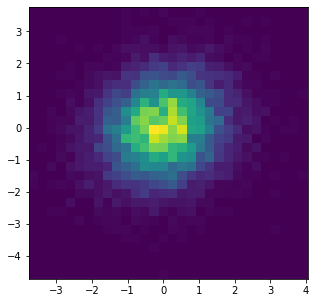

In [14]:
plt.figure(figsize=(5,5))
plt.hist2d(yj.cpu().detach()[:,0].numpy(),yj.cpu()[:,1].detach().numpy(),bins=30)
plt.show()

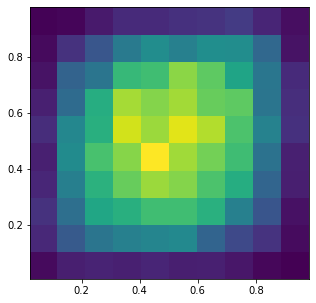

In [15]:
plt.figure(figsize=(5,5))
plt.hist2d(xj.cpu().detach()[:,0].numpy(),xj.cpu()[:,1].detach().numpy())
plt.show()

In [16]:
prior_mu =  torch.tensor(0.).to(device)
prior_sig =  torch.tensor(10.).to(device)
prior = torch.distributions.normal.Normal(prior_mu,prior_sig)

sampler = FactorizedFlowPrior(d=2,prior_1d=prior)
nnflow = NNFlow(d=2,dh=5,nh=3)
sflow = SigmoidFlow(d=2)
sampler.cuda(device=device)
nnflow.cuda(device=device)
sflow.cuda(device=device)

nbatch=100000
zj = sampler(nbatch)
yj = nnflow(zj)
xj = sflow(yj)
j = torch.exp(xj[:,-1])
v,r=torch.var_mean(j)
v=v.detach().cpu().item()
r=r.detach().cpu().item()
print("{}+/-{}".format(r,sqrt(v/nbatch)))

1.0219788551330566+/-0.00841000123685086


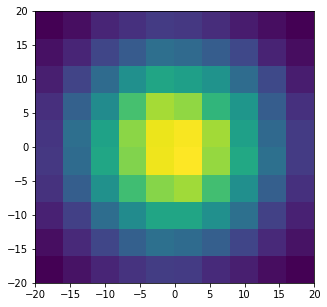

In [17]:
plt.figure(figsize=(5,5))
plt.hist2d(zj.cpu()[:,0].numpy(),zj.cpu()[:,1].numpy(),range=((-20,20),(-20,20)))
plt.show()

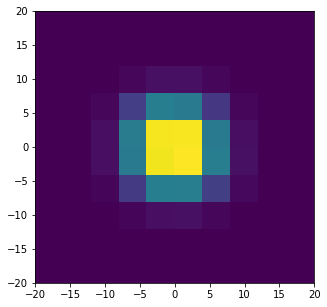

In [18]:
plt.figure(figsize=(5,5))
plt.hist2d(yj.cpu().detach()[:,0].numpy(),yj.cpu()[:,1].detach().numpy(),range=((-20,20.),(-20,20.)))
plt.show()

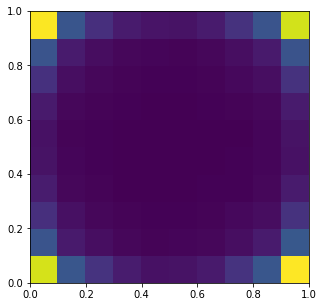

In [19]:
plt.figure(figsize=(5,5))
plt.hist2d(xj.cpu().detach()[:,0].numpy(),xj.cpu()[:,1].detach().numpy(),range=((0,1.),(0,1.)))
plt.show()

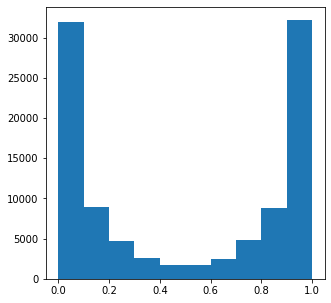

In [20]:
plt.figure(figsize=(5,5))
plt.hist(xj.cpu().detach()[:,0].numpy())
plt.show()

In [ ]:
def f(x):
    return 1.

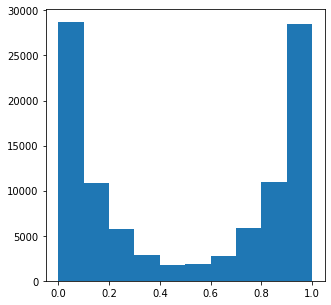

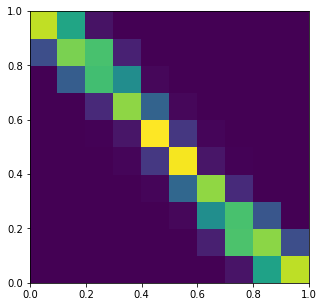

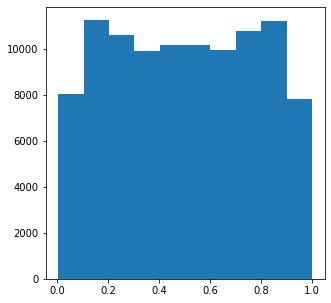

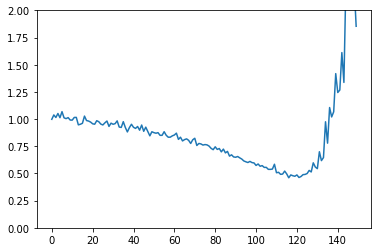

0.4601142108440399


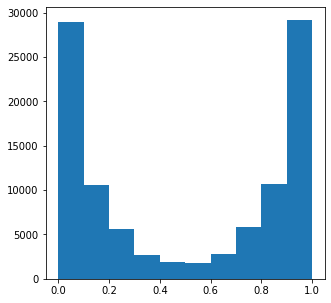

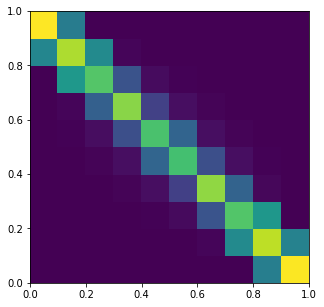

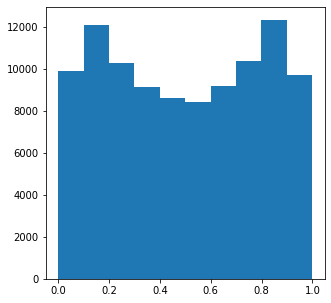

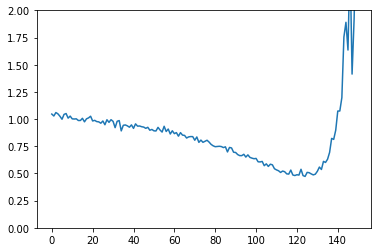

0.4725583493709564


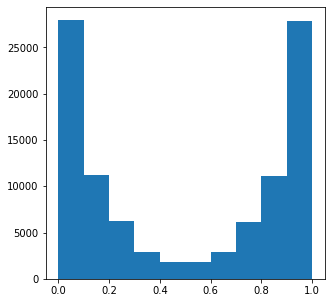

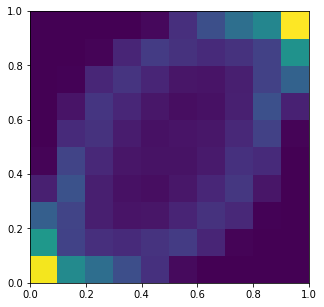

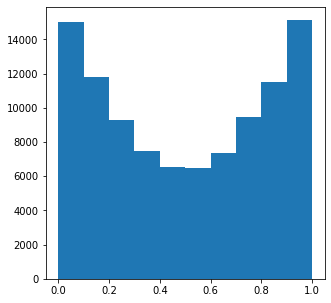

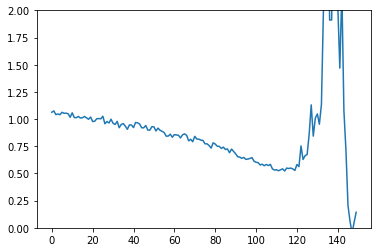

-0.048895563930273056


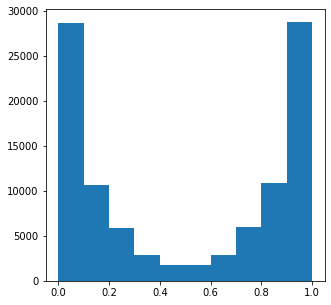

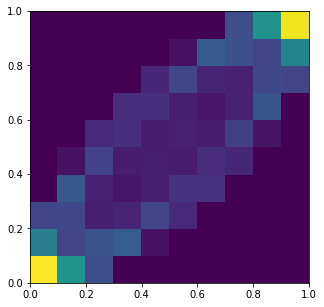

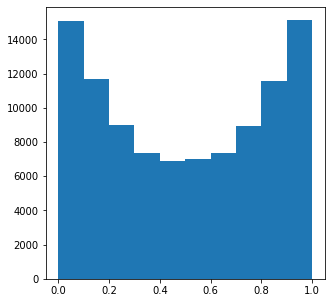

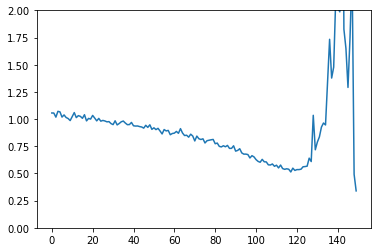

0.33944347500801086


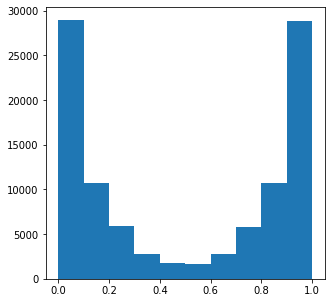

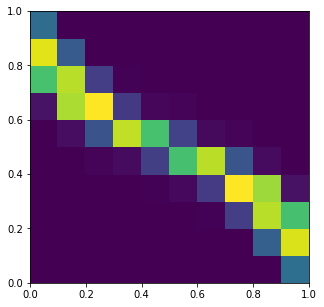

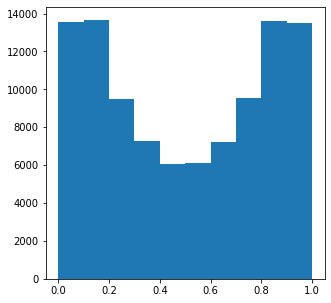

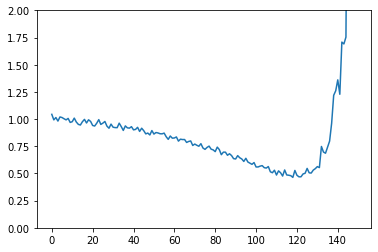

0.4636252224445343


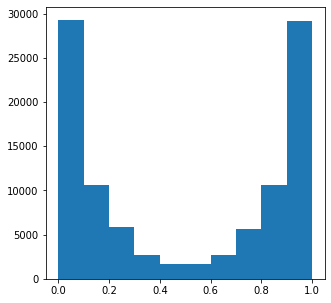

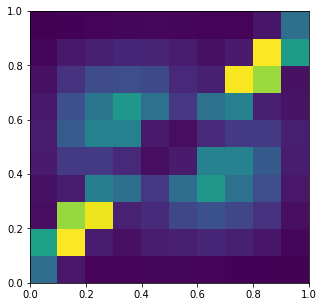

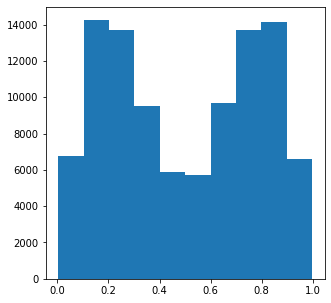

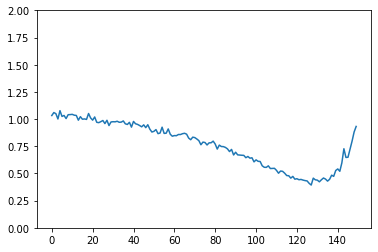

0.39326730370521545


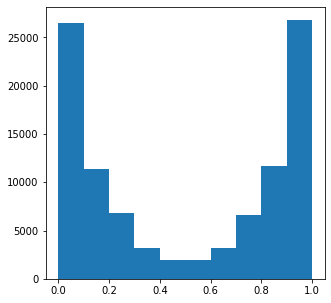

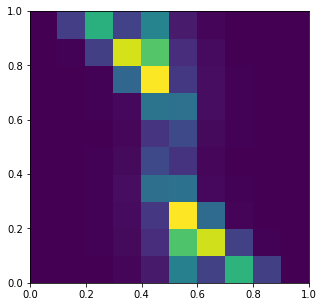

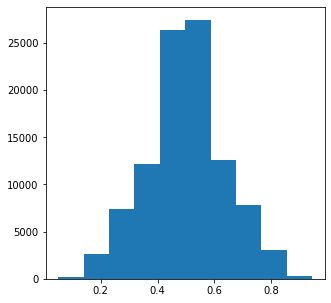

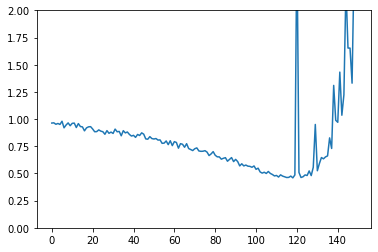

0.45938214659690857


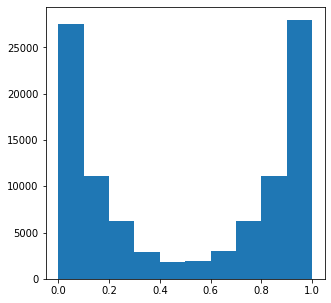

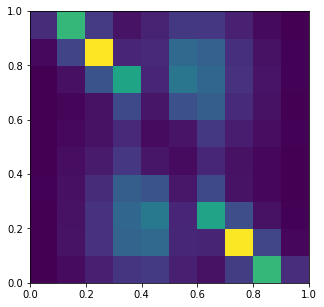

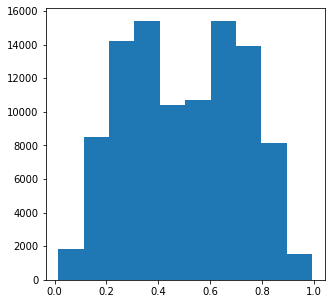

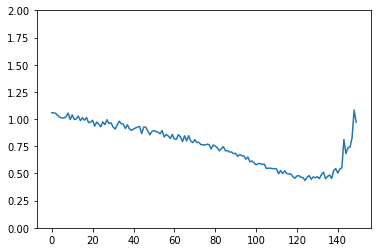

0.4346705675125122


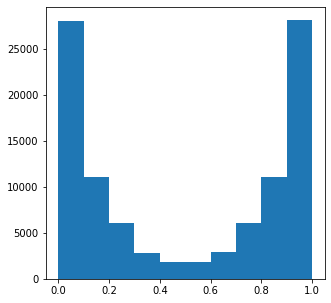

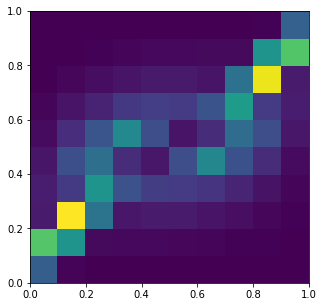

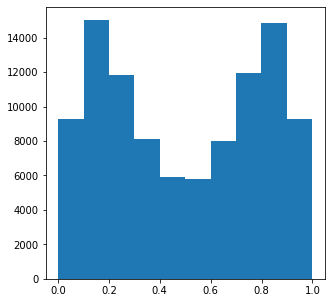

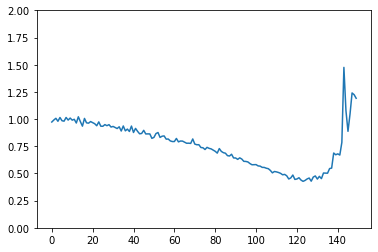

0.42718276381492615


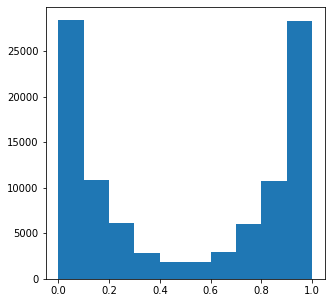

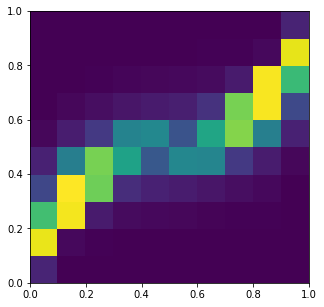

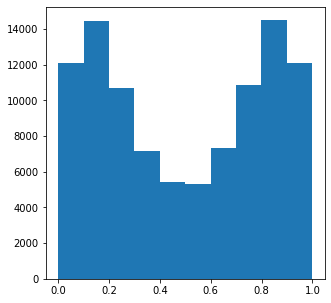

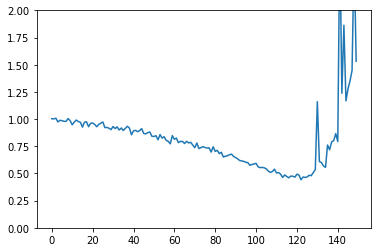

0.44173112511634827


In [16]:
# optimizing a flat function. The PDF is 1/j so the grad DKL = E(x~1/j)(j*log(j))
nbatch=100000

prior_mu =  torch.tensor(0.).to(device)
prior_sig =  torch.tensor(10.).to(device)
prior = torch.distributions.normal.Normal(prior_mu,prior_sig)
minLs = []

for j in range(10):
    sampler = FactorizedFlowPrior(d=2,prior_1d=prior)
    nnflow = NNFlow(d=2,dh=32,nh=4)
    sflow = SigmoidFlow(d=2)
    sampler.cuda(device=device)
    nnflow.cuda(device=device)
    sflow.cuda(device=device)

    optim = torch.optim.Adam(nnflow.parameters(), lr=1.e-4)

    Ls = []

    training_steps = tqdm(range(150))
    training_steps.set_description("Loss:")

    for i in training_steps:
        optim.zero_grad()
        zj = sampler(nbatch)
        yj = nnflow(zj)
        xj = sflow(yj)
        j = torch.exp(xj[:,-1])
        x = xj[:,:-1].detach()

        if i ==0:
            plt.figure(figsize=(5,5))
            plt.hist(xj.cpu().detach()[:,0].numpy())
            plt.show()

    #     if not torch.all(j>0):
    #         print("alert")
    #         print(torch.min(j))
    #         plt.figure(figsize=(5,5))
    #         plt.hist2d(xj.cpu().detach()[:,0].numpy(),xj.cpu()[:,1].detach().numpy(),range=((0,1.),(0,1.)))
    #         plt.show()
    #         plt.figure(figsize=(5,5))
    #         plt.hist(xj.cpu().detach()[:,0].numpy())
    #         plt.show()        
    #         break

        L = torch.mean(j*torch.log(j+1.e-6))
        L.backward()    
        optim.step()

        Ls.append(L.cpu().detach().item())
        training_steps.set_description("Loss: {:.5f} | Int: {:.5}".format(L.cpu().detach().item(),torch.mean(j).cpu().detach().item()))


    plt.figure(figsize=(5,5))
    plt.hist2d(xj.cpu().detach()[:,0].numpy(),xj.cpu()[:,1].detach().numpy(),range=((0,1.),(0,1.)))
    plt.show()
    plt.figure(figsize=(5,5))
    plt.hist(xj.cpu().detach()[:,0].numpy())
    plt.show() 
    #plt.yscale("log")
    plt.ylim((0,2.))
    plt.plot(Ls)
    plt.show()
    print(min(Ls))
    minLs.append(min(Ls))

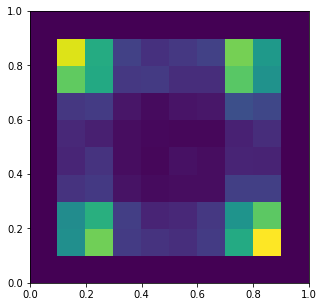

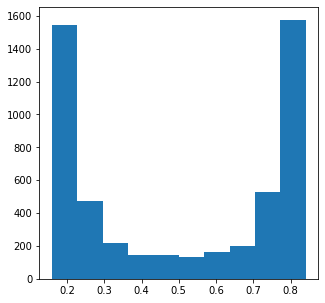

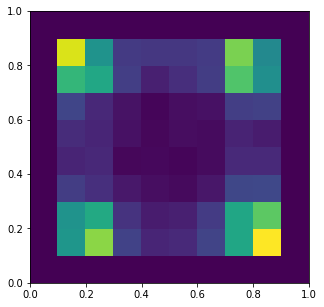

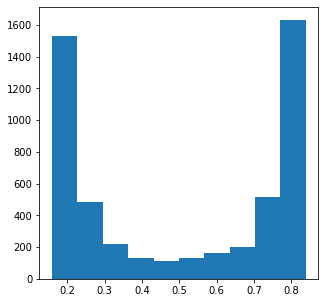

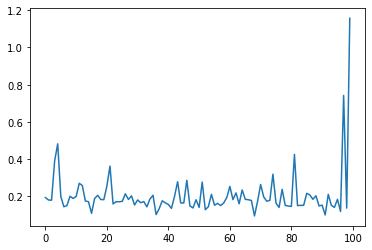

0.09492246061563492


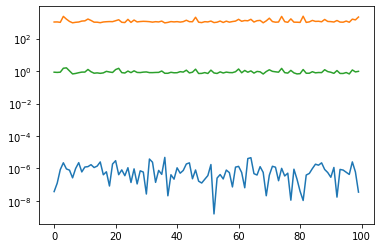

In [49]:
# optimizing a flat function. The PDF is 1/j so the grad DKL = E(x~1/j)(j*log(j))
nbatch=5120

prior_mu =  torch.tensor(0.).to(device)
prior_sig =  torch.tensor(1.).to(device)
prior = torch.distributions.normal.Normal(prior_mu,prior_sig)
minLs = []

for j in range(1):
    sampler = FactorizedFlowPrior(d=2,prior_1d=prior)
    nnflow = NNFlow(d=2,dh=64,nh=5)
    sflow = SigmoidFlow(d=2)
    sampler.cuda(device=device)
    nnflow.cuda(device=device)
    sflow.cuda(device=device)

    optim = torch.optim.SGD(nnflow.parameters(), lr=1.e-6)

    Ls = []
    gmins = []
    gmaxs = []
    gmeans = []

    training_steps = tqdm(range(100))

    for i in training_steps:
        optim.zero_grad()
        zj = sampler(nbatch)
        yj = nnflow(zj)
        xj = sflow(yj)
        j = torch.exp(xj[:,-1])
        x = xj[:,:-1].detach()

        if i ==0:
            plt.figure(figsize=(5,5))
            plt.hist2d(xj.cpu().detach()[:,0].numpy(),xj.cpu()[:,1].detach().numpy(),range=((0,1.),(0,1.)))
            plt.show()            
            plt.figure(figsize=(5,5))
            plt.hist(xj.cpu().detach()[:,0].numpy())
            plt.show()

    #     if not torch.all(j>0):
    #         print("alert")
    #         print(torch.min(j))
    #         plt.figure(figsize=(5,5))
    #         plt.hist2d(xj.cpu().detach()[:,0].numpy(),xj.cpu()[:,1].detach().numpy(),range=((0,1.),(0,1.)))
    #         plt.show()
    #         plt.figure(figsize=(5,5))
    #         plt.hist(xj.cpu().detach()[:,0].numpy())
    #         plt.show()        
    #         break

        L = torch.mean(j.detach()*torch.log(j+1.e-5))
        L.backward()
        torch.nn.utils.clip_grad_norm_(nnflow.parameters(), 1.)        
        optim.step()

        Ls.append(L.cpu().detach().item())
        training_steps.set_description("Loss: {:.5f}\nVar: {:.5f}\nInt: {:.5}".format(L.cpu().detach().item(),torch.var(j).cpu().detach(),torch.mean(j).cpu().detach().item()))
        
        gmax = float("-inf")
        gmin = float("inf")
        gmean = 0
        np=len(optim.param_groups[0]["params"])
        for p in optim.param_groups[0]["params"]:
            if p.grad is None:
                continue
            rgrads = torch.abs(p.grad/p.detach()).cpu()
            gmax = max(gmax,torch.max(rgrads).item())
            gmin = min(gmin,torch.min(rgrads).item())
            gmean += torch.mean(rgrads).item()/np
        gmins.append(gmin)
        gmaxs.append(gmax)
        gmeans.append(gmean)
     
    

    plt.figure(figsize=(5,5))
    plt.hist2d(xj.cpu().detach()[:,0].numpy(),xj.cpu()[:,1].detach().numpy(),range=((0,1.),(0,1.)))
    plt.show()
    plt.figure(figsize=(5,5))
    plt.hist(xj.cpu().detach()[:,0].numpy())
    plt.show() 
#    plt.yscale("log")
#    plt.ylim((0.,2))
    plt.plot(Ls)
    plt.show()
    print(min(Ls))
    minLs.append(min(Ls))
    
    plt.yscale("log")
    plt.plot(gmins)
    plt.plot(gmaxs)
    plt.plot(gmeans)

In [112]:
optim.zero_grad()
zj = sampler(nbatch)
yj = nnflow(zj)
xj = sflow(yj)
j = torch.exp(xj[:,-1])
x = xj[:,:-1].detach()
L = torch.mean(j*torch.log(j+1.e-6))
L.backward()    

gmax = float("-inf")
gmin = float("inf")
gmean = 0
np=len(optim.param_groups[0]["params"])
for p in optim.param_groups[0]["params"]:
    if p.grad is None:
        continue
    rgrads = torch.abs(p.grad/p.detach()).cpu()
    gmax = max(gmax,torch.max(rgrads).item())
    gmin = min(gmin,torch.min(rgrads).item())
    gmean += torch.mean(rgrads).item()/np

print(gmax,gmin,gmean)

8917.1875 1.3678552477358608e-06 4.291743409633637


In [20]:
torch.max(xj[:,:-1])

tensor(0.9998, device='cuda:1', grad_fn=<MaxBackward1>)

In [67]:
gmax = float("-inf")
gmin = float("inf")
gmean = 0
np=len(optim.param_groups[0]["params"])
for p in optim.param_groups[0]["params"]:
    if p.grad is None:
        continue
    rgrads = torch.abs(p.grad/p.detach()).cpu()
    gmax = max(gmax,torch.min(rgrads).item())
    gmin = min(gmin,torch.max(rgrads).item())
    gmean += torch.mean(rgrads).item()/np